# Regression with a feed forward neural network
## Predict surface temperature atmosphere-ocean correlations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import cartopy.crs as ccrs

import tensorflow as tf
from tensorflow import keras

from mlcdc import SurfaceFeeder, histoscatter

In [2]:
plt.style.use('./mlcdc.mplstyle')

In [3]:
ds = xr.open_zarr('../data/tcorr.predictors0.10lon.10lat.-1alev.-1olev.-1member.zarr')
ds['log10_atm_tprcp'] = np.log10(ds.atm_tprcp)
ds['atm_speed_srf'] = ds.atm_wind_speed.isel(alev=-1)
ds['ocn_speed_srf'] = ds.ocn_speed.isel(olev=0)
ds['ocn_u_srf'] = ds['ocn_u'].isel(olev=0)
ds['ocn_v_srf'] = ds['ocn_v'].isel(olev=0)
ds['log10_atm_tprcp'].attrs['long_name'] = 'derived log10 of tprcp'
ds['atm_speed_srf'].attrs['long_name'] = 'derived atmospheric surface wind speed'
ds['ocn_speed_srf'].attrs['long_name'] = 'derived ocean surface current speed'
ds['ocn_u_srf'].attrs['long_name'] = 'derived zonal ocean surface current speed'
ds['ocn_v_srf'].attrs['long_name'] = 'derived meridional ocean surface current speed'

ds['ocn_ubtav'] = ds['ocn_ubtav'].isel(olev=0)
ds['ocn_vbtav'] = ds['ocn_vbtav'].isel(olev=0)
ds['ocn_baro_srf'] = np.sqrt(ds.ocn_ubtav**2 + ds.ocn_vbtav**2)
ds['ocn_baro_srf'].attrs['long_name'] = 'derived barotropic ocean current speed'

ds['corr_atm_ocn'] = ds.corr_atm_ocn.isel(olev=0,alev=-1)

In [4]:
features_and_labels = [
    #'atm_cnvprcp_ave', # no idea what this is
    #'atm_ast',
    #'atm_T',
    'atm_q2m',
    'atm_qrain',
    'atm_t2m',
    #'atm_totprcp_ave',
    'atm_tprcp',
    #'log10_atm_tprcp',
    #'atm_u_srf',
    #'atm_v_srf',
    'atm_speed_srf',
    'ocn_MEKE',
    #'ocn_MEKE_Kh', # probably need MEKE, if anything, not the diffusivity ...
    'ocn_MLD',
    #'ocn_MLD_MLE_filtered', # just use instantaneous, not time filtered version...
    #'ocn_ave_ssh', # use instantaneous version
    'ocn_sfc',
    'ocn_sst',
    #'ocn_u_srf',
    #'ocn_v_srf',
    'ocn_speed_srf',
    'ocn_baro_srf',
    #'ocn_Temp',
    'corr_atm_ocn'
]

In [5]:
for key in features_and_labels:
    if 'long_name' in ds[key].attrs:
        print(f"{key:<24s}: {ds[key].long_name}")

atm_q2m                 : q2m
atm_qrain               : qrain
atm_t2m                 : t2m
atm_tprcp               : tprcp
atm_speed_srf           : derived atmospheric surface wind speed
ocn_MEKE                : Mesoscale Eddy Kinetic Energy
ocn_MLD                 : Instantaneous active mixing layer depth
ocn_sfc                 : Free surface Height
ocn_sst                 : Sea surface temperature (derived)
ocn_speed_srf           : derived ocean surface current speed
ocn_baro_srf            : derived barotropic ocean current speed


### Look at the data

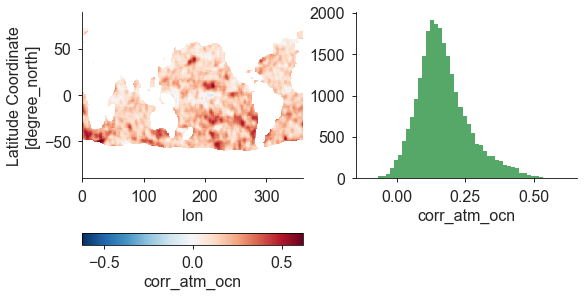

In [6]:
fig, axs = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)
ds.corr_atm_ocn.plot(ax=axs[0],cbar_kwargs={'orientation':'horizontal'})
ds.corr_atm_ocn.plot.hist(ax=axs[1], bins=50);

In [7]:
df = ds[features_and_labels].to_dataframe()

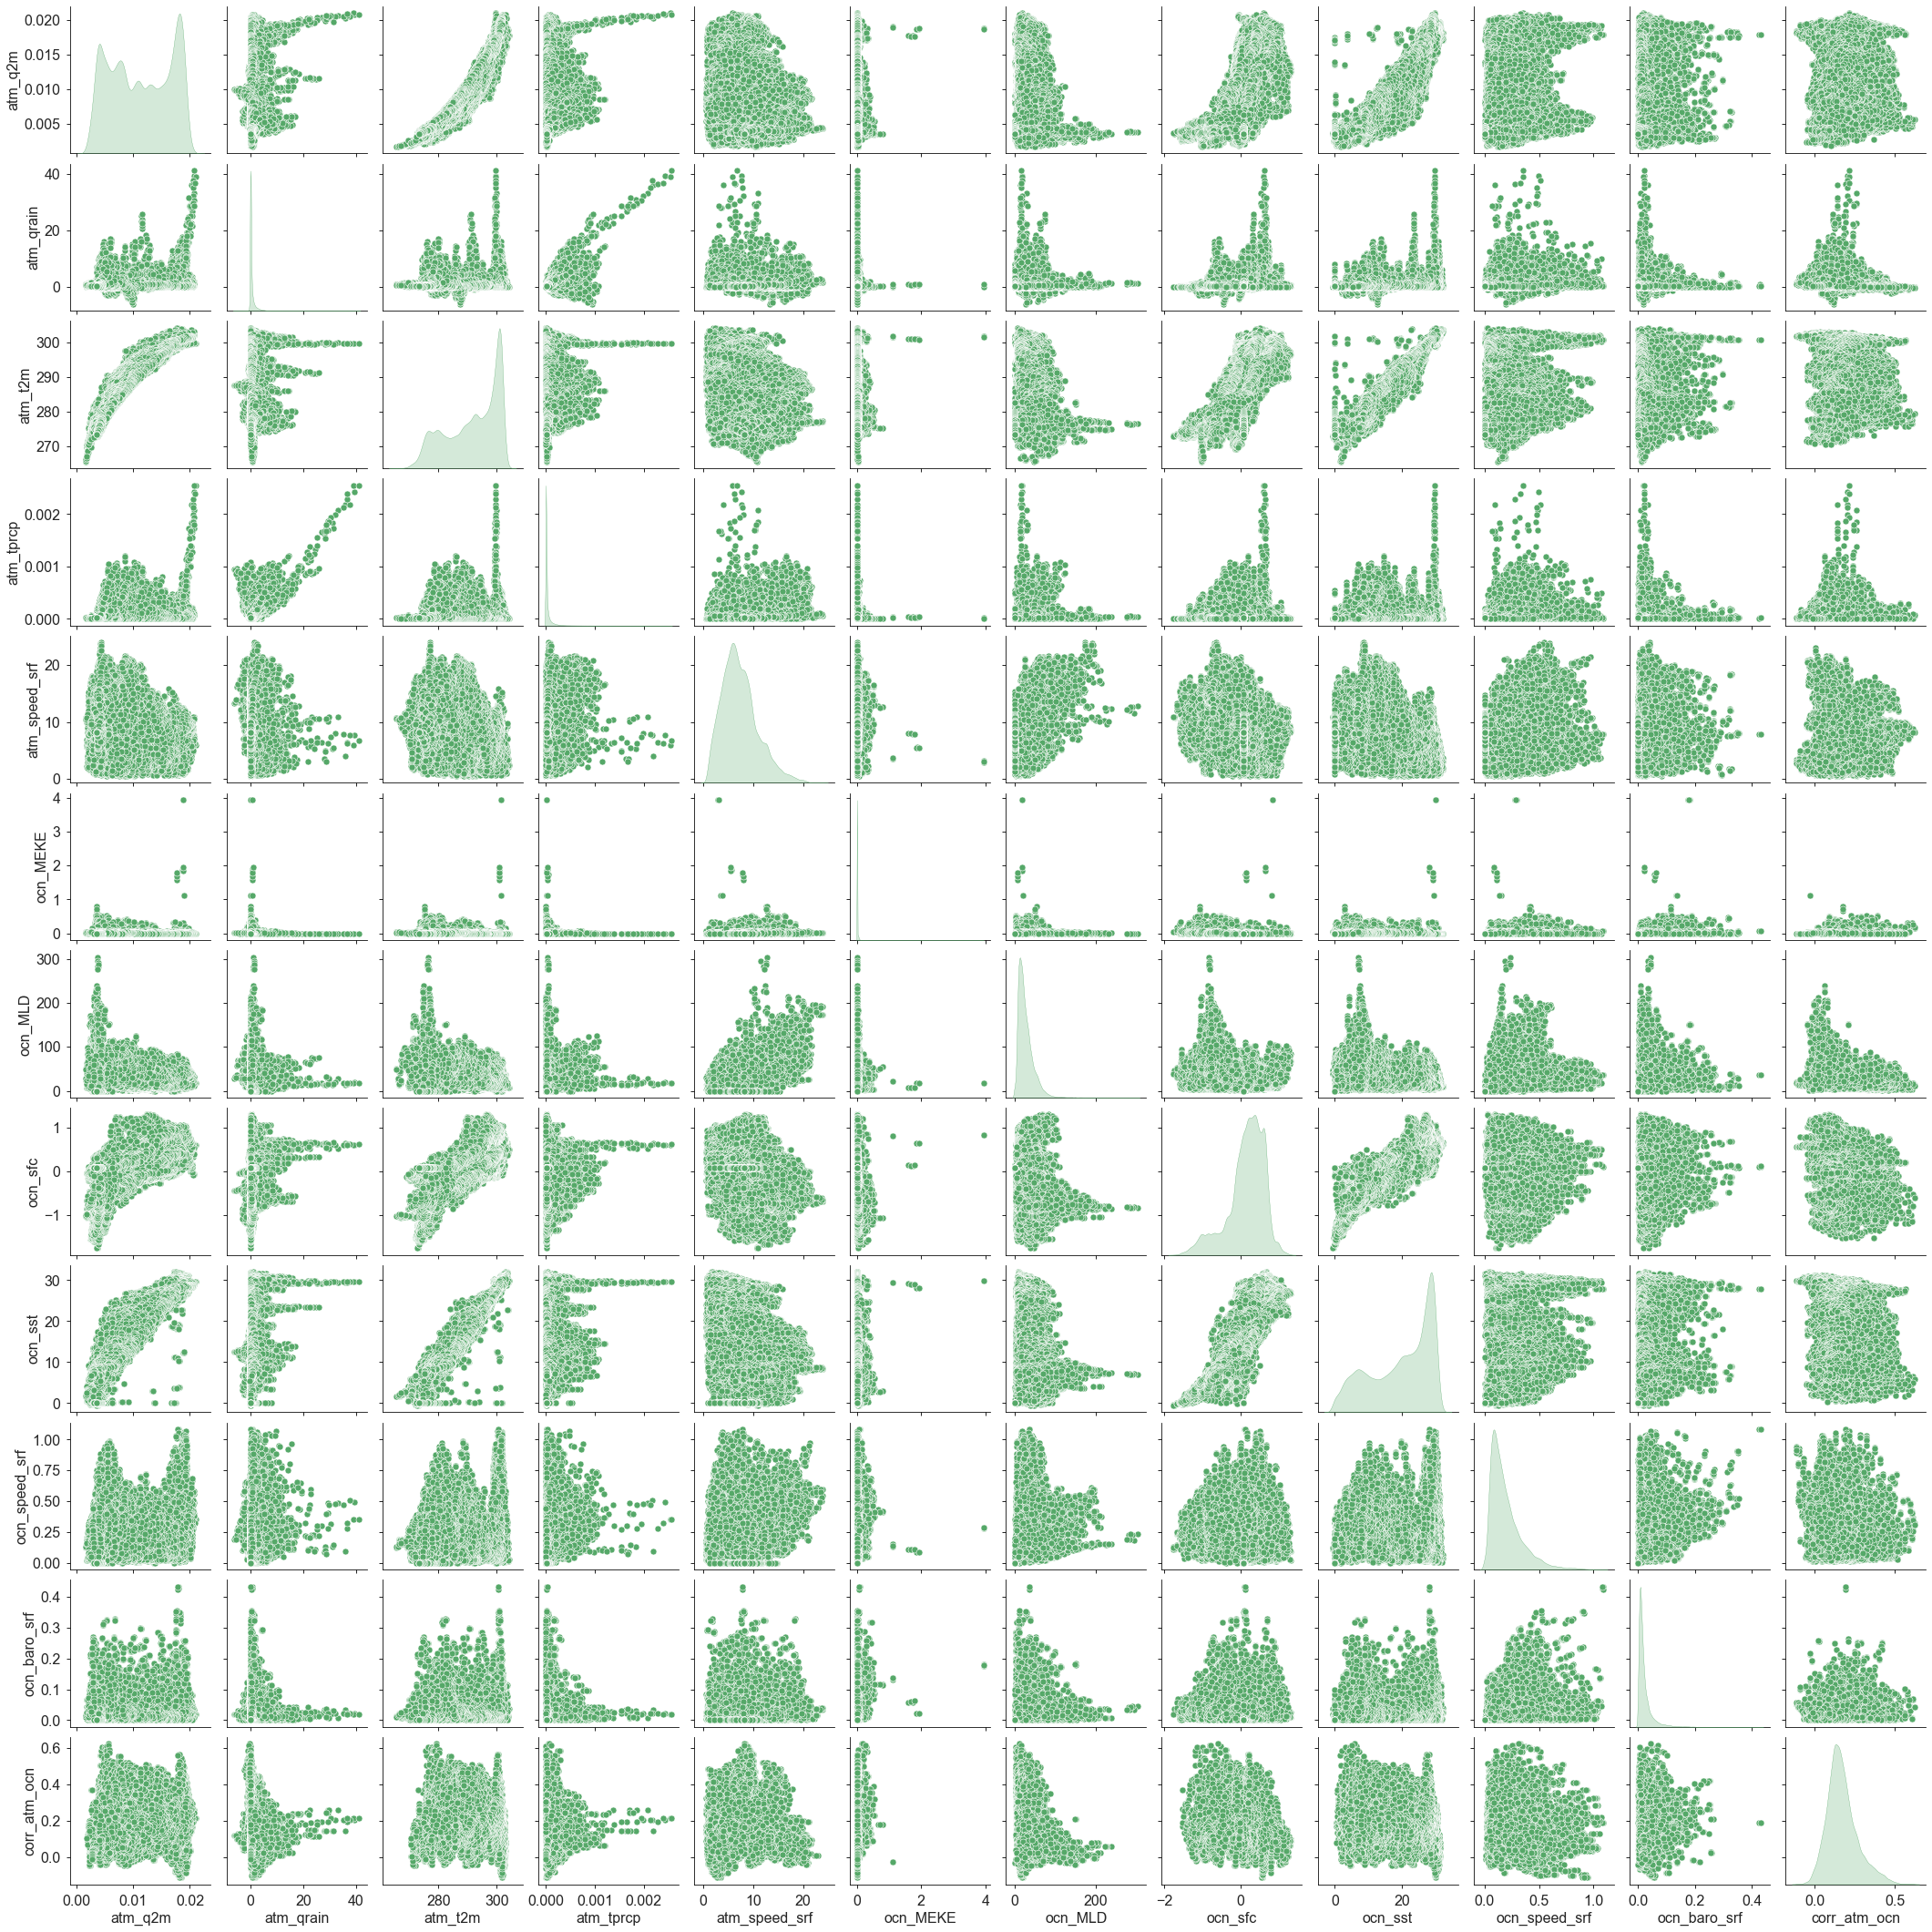

In [9]:
sns.pairplot(df, diag_kind='kde')

It is likely the case that we can trim the `features` list to be more optimal, given that there is little structure 
apparent in the joint scatter plots for many features.

## Prepare the data

In [8]:
features = features_and_labels.copy()
features.remove('corr_atm_ocn')

In [9]:
kf = SurfaceFeeder(feature_names=features,
                 label_name='corr_atm_ocn',
                 mask_name='ocn_mask',
                 training_fraction=0.8,
                 load_into_memory=True)

In [10]:
kf

KerasFeeder:

    Features:
        atm_q2m, atm_qrain, atm_t2m, atm_tprcp, atm_speed_srf, ocn_MEKE, ocn_MLD, ocn_sfc, ocn_sst, ocn_speed_srf, ocn_baro_srf
        status = unset

    Labels:
        corr_atm_ocn
        status = unset

    Inputs:
        None
        status = unset

 --- 
    Training Fraction       : 0.8
    Normalize Data          : True
    Load into Memory        : True
    Num. training samples   : None

In [11]:
kf(ds)

In [12]:
kf

KerasFeeder:

    Features:
        atm_q2m, atm_qrain, atm_t2m, atm_tprcp, atm_speed_srf, ocn_MEKE, ocn_MLD, ocn_sfc, ocn_sst, ocn_speed_srf, ocn_baro_srf
        status = set

    Labels:
        corr_atm_ocn
        status = set

    Inputs:
        [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_q2m')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_qrain')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_t2m')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_tprcp')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_speed_srf')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ocn_MEKE')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ocn_MLD')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ocn_sfc')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ocn_sst')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by laye

## Create the model

Input layers are created in `KerasFeeder`, for simple linear regression, just merge the inputs and feed to output.

In [13]:
def make_model(xkf, regularizer=keras.regularizers.L2, regularization=1e-6,
               hidden_units=[16],
               hidden_activation=None,
               learning_rate=1e-4,
              ):
    
    if not isinstance(hidden_activation, (list, tuple, np.ndarray)):
        hidden_activation = [hidden_activation] * len(hidden_units)
    
    hidden = keras.layers.concatenate(xkf.inputs)
    
    for units, activation in zip(hidden_units, hidden_activation):
        hidden = keras.layers.Dense(
            units=units,
            activation=activation,
            kernel_regularizer=regularizer(regularization),
            bias_regularizer=regularizer(regularization),
        )(hidden)
    
    output = keras.layers.Dense(
        activation='tanh',
        units=1, name='ao_corr'
    )(hidden)
    
    # stick it together
    model = keras.Model(
        inputs=xkf.inputs,
        outputs=[output]
    )
    
    # compile
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=learning_rate,
        ),
        #loss=keras.losses.Huber(delta=1),
        #loss=keras.losses.MeanSquaredError(),
        loss=keras.losses.MeanAbsoluteError(),
    )
    return model

In [14]:
#units = [128]*3
units = [64]*6
activation = 'swish' #['tanh', 'tanh']

model = make_model(kf,
                   regularizer=keras.regularizers.L1,
                   regularization=1e-7,
                   hidden_units=units,
                   hidden_activation=activation,
                   learning_rate=1e-3,
                )

2022-09-09 09:54:05.317683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 atm_q2m (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 atm_qrain (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 atm_t2m (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 atm_tprcp (InputLayer)         [(None, 1)]          0           []                               
                                                                                              

In [24]:
%%time
history = model.fit(
    x=kf.x_training, 
    y=kf.labels['training'].values,
    epochs=200,
    batch_size=128,
    validation_split=0.2,
    verbose=False,
)

CPU times: user 5min 38s, sys: 31.7 s, total: 6min 10s
Wall time: 3min 41s


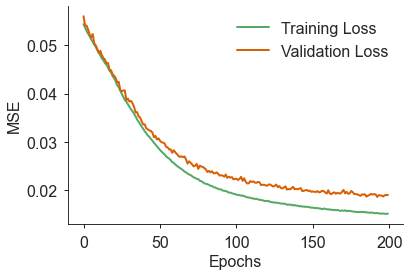

In [25]:
fig,ax=plt.subplots()
for key, label in zip(['loss','val_loss'],
                      ['Training Loss', 'Validation Loss']):
    ax.plot(history.history[key],label=label)
ax.set(xlabel='Epochs', ylabel='MSE')
ax.legend()

In [26]:
prediction = model.predict(kf.x_testing)
xpred = xr.DataArray(prediction.squeeze(),coords=kf.labels['testing'].coords, dims=kf.labels['testing'].dims)

619/619 [==============================] - 1s 1ms/step


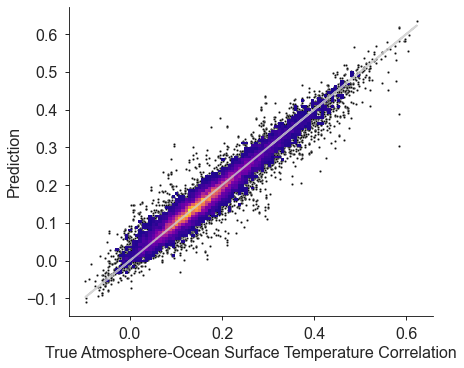

In [40]:
fig, ax = plt.subplots(figsize=(6,5), constrained_layout=True)

histoscatter(
    x=kf.labels['testing'].values,
    y=xpred.values,
    ax=ax,
)
ax.set(xlabel="True Atmosphere-Ocean Surface Temperature Correlation",
       ylabel="Prediction",
      )
# pdf for docs, jpg for github ... kind of annoying
fig.savefig("../figures/surface_correlation_prediction_histogram.jpg", dpi=300, bbox_inches='tight')
fig.savefig("../figures/surface_correlation_prediction_histogram.pdf", bbox_inches='tight')

This next plot has the marginal distributions, I'm not sure if it adds a ton.

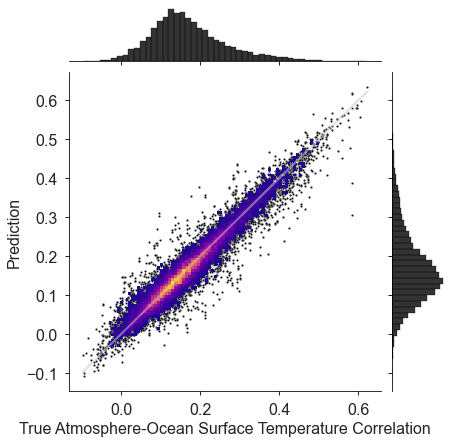

In [29]:
x=kf.labels['testing'].values
y=xpred.values

jp = sns.jointplot(
    x=x,
    y=y,
    kind='hist',
    cmap="plasma",
    joint_kws={
        'bins':100,
        'pthresh':0.05,
    },
    marginal_kws={
        'color':'black',
        'alpha':.8,
        'bins':50,
    }
)
sns.scatterplot(x=x,
                y=y,
                s=5,
                color=".05",
                ax=jp.ax_joint,
                zorder=0
               )

jp.ax_joint.plot(x, x, color=".8", alpha=.5)

jp.set_axis_labels(
    xlabel="True Atmosphere-Ocean Surface Temperature Correlation",
    ylabel="Prediction"
)

### Notes on what mattered

- Setting regularization to ~$10^{-7} - 10^{-8}$ is what finally got the prediction to be at least span the 1:1 line 
- When regularization is too high, predictions well be a flat line (near zero)
- Low learning rate ~$10^{-3} - 10^{-4}$ works well
- Batch size 128 seems to be a good balance of performance and speed
- Hidden activation function "swish" and "tanh" work well, "sigmoid" performs poorly. Didn't see success with ReLU
- Loss function (MSE, MAE, Huber) doesn't really matter

### Future considerations

- How many layers is actually necessary? How wide is necessary? Activation functions?
- Which features are really necessary? Score the usefulness/trim.
- Residual Neural Network architecture
- Can we add uncertainty?